In [1]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

from dtw import dtw

import tensorflow as tf

import utils

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



2023-10-01 17:01:15.915254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = '/project/data/'
empty_csv = utils.get_empty_csv(data_dir)
files_dict = utils.get_files_dict(data_dir)

# print empty .csv files and unlabeled smartwatch readings
print(empty_csv[:2])

['/project/data/5cadf72d23feb407ddebbe4d_0_KH2018_movements.csv', '/project/data/5ca4b45123feb407ddeb7b99_0_KH2018_movements.csv']


In [3]:
# print files dictionary
for k, v in files_dict.items():
    print(k, v)

5c9108fc23feb407ddeb5e1e ['/project/data/5c9108fc23feb407ddeb5e1e.pbz2', '/project/data/5c9108fc23feb407ddeb5e1e_1_KH2018_movements_seq.csv']
5ca4b9bc23feb407ddeb7bff ['/project/data/5ca4b9bc23feb407ddeb7bff.pbz2', '/project/data/5ca4b9bc23feb407ddeb7bff_1_KH2018_movements_seq.csv']
5e6a72353a210055f9c12f45 ['/project/data/5e6a72353a210055f9c12f45.pbz2', '/project/data/5e6a72353a210055f9c12f45_0_KH2018_movements_seq.csv']
5dcc2a138a03930ee46d34f7 ['/project/data/5dcc2a138a03930ee46d34f7.pbz2', '/project/data/5dcc2a138a03930ee46d34f7_1_KH2018_movements_seq.csv']
5defc0eb830c310a053c047a ['/project/data/5defc0eb830c310a053c047a.pbz2', '/project/data/5defc0eb830c310a053c047a_1_KH2018_movements_seq.csv']
5ccc0c3523feb407ddebceb1 ['/project/data/5ccc0c3523feb407ddebceb1.pbz2', '/project/data/5ccc0c3523feb407ddebceb1_1_KH2018_movements_seq.csv']
5cadf68623feb407ddebbe4b ['/project/data/5cadf68623feb407ddebbe4b.pbz2', '/project/data/5cadf68623feb407ddebbe4b_1_KH2018_movements_seq.csv']
5e5d39

In [4]:
exp = '5c9108fc23feb407ddeb5e1e'

pbz2_path = files_dict[exp][0]
csv_path = files_dict[exp][1]

_, readings = utils.read_pbz2(pbz2_path)
labels = pd.read_csv(csv_path)
df = utils.merge_dfs(readings, labels)

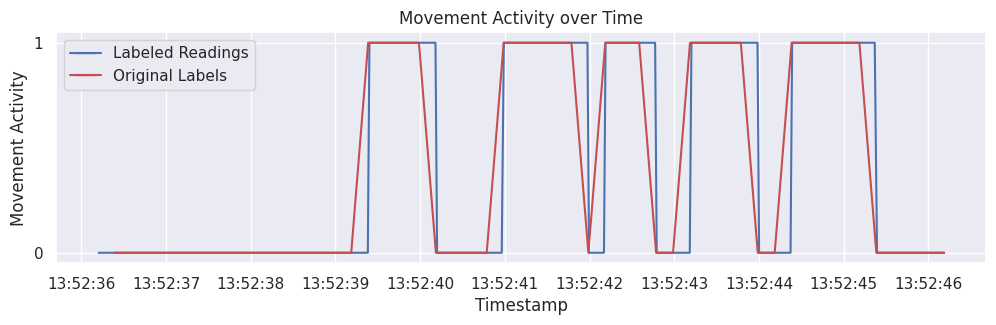

In [5]:
utils.plot_move(df, labels, 180, 190)

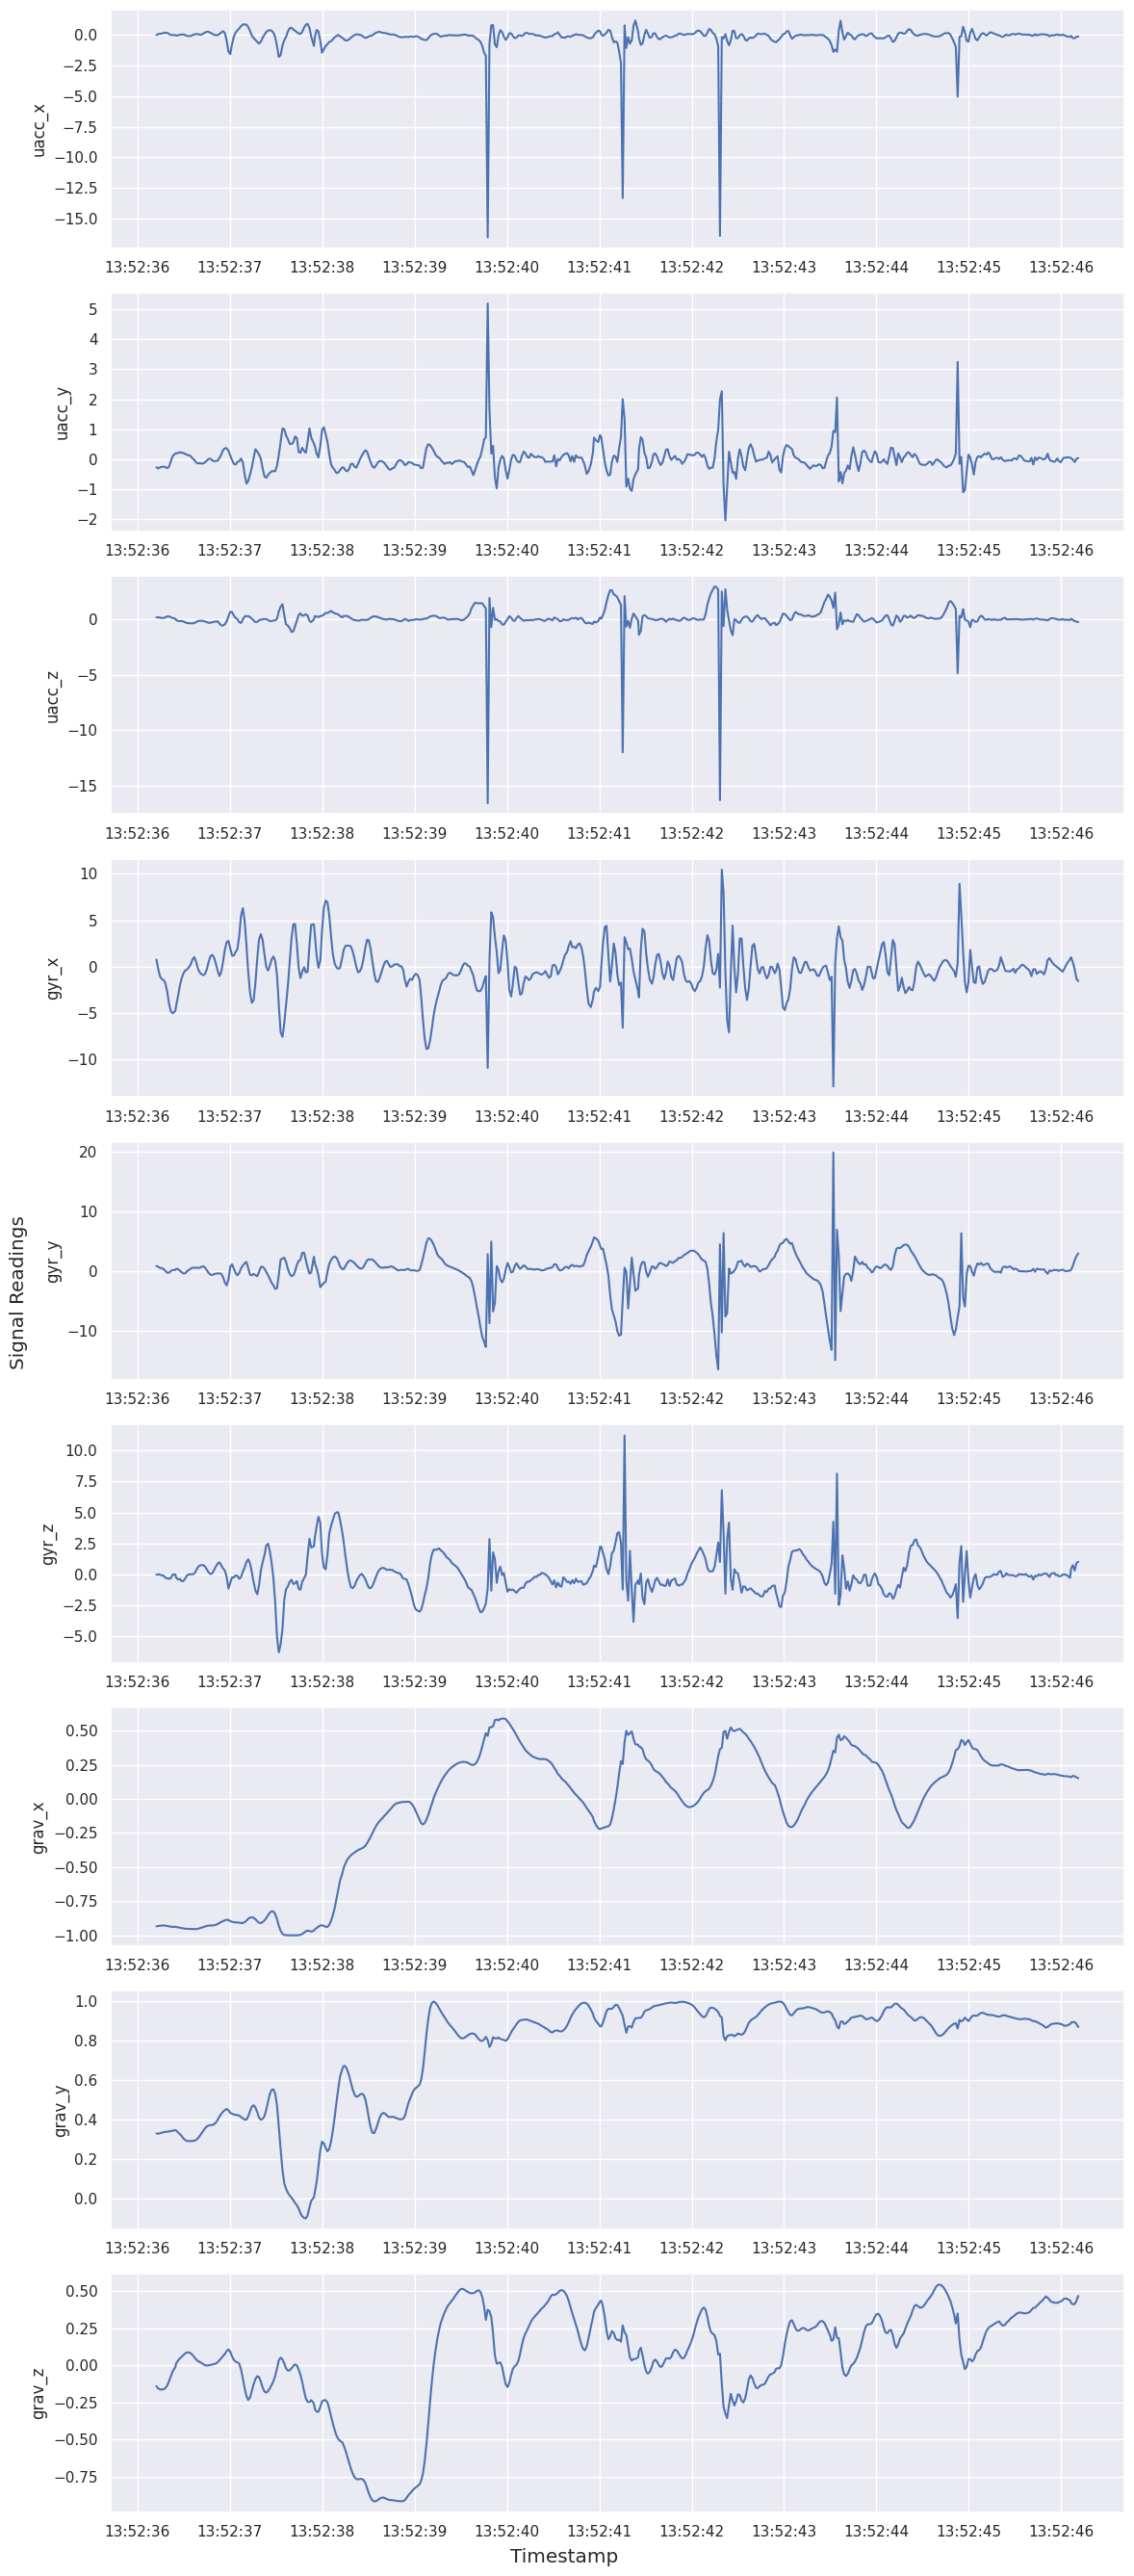

In [6]:
utils.plot_signal(df.iloc[:, :-1], 180, 190)

In [7]:
df = utils.window_df(df, '2S', '1S')
df.head()

,uacc_x_mean,uacc_x_std,uacc_x_median,uacc_x_max,uacc_x_min,uacc_x_iqr,uacc_y_mean,uacc_y_std,uacc_y_median,uacc_y_max,...,grav_y_max,grav_y_min,grav_y_iqr,grav_z_mean,grav_z_std,grav_z_median,grav_z_max,grav_z_min,grav_z_iqr,Movement
0,0.024235,0.119250,-0.000867,0.408454,-0.180192,0.083424,0.012473,0.072678,0.003738,0.264216,...,0.457776,0.313842,0.061735,-0.478554,0.232105,-0.475249,-0.134049,-0.815879,0.480905,No Movement
1,-0.016415,0.045448,-0.016365,0.110204,-0.180192,0.041260,0.002324,0.061977,-0.006526,0.264216,...,0.402670,0.313842,0.028836,-0.201862,0.118268,-0.146826,-0.092958,-0.470912,0.068863,No Movement
2,-0.008021,0.028278,-0.010410,0.048762,-0.069775,0.037134,-0.008048,0.053916,-0.007836,0.113955,...,0.391710,0.279984,0.058041,-0.157362,0.034782,-0.165496,-0.092958,-0.215796,0.044164,No Movement
3,-0.012239,0.032447,-0.013155,0.060551,-0.131582,0.031711,-0.013506,0.041873,-0.013446,0.081161,...,0.383721,0.224350,0.071729,-0.181264,0.014467,-0.177012,-0.157996,-0.215796,0.015691,No Movement
4,-0.007421,0.042695,-0.014243,0.098784,-0.131582,0.050105,-0.017581,0.028997,-0.017413,0.073503,...,0.348410,0.224350,0.045481,-0.200611,0.030261,-0.190627,-0.157996,-0.257786,0.052292,No Movement


In [8]:
print(df.Movement.value_counts())

No Movement    181
Spider          24
Peck            22
Pray            22
Nose            21
Crab            14
Lame_fox        10
Bear             7
Clapping         7
Name: Movement, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


X = df.drop('Movement', axis=1).values
y = df['Movement'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Choose a classifier (e.g., Random Forest)
clf = RandomForestClassifier()

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

Accuracy: 0.7956989247311828
[[ 0  0  0  0  1  0  0  0  0]
 [ 0  2  0  0  1  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  0  0  1  1  0  0  0  0]
 [ 0  0  1  0 47  0  1  1  0]
 [ 0  0  0  0  3  6  0  0  0]
 [ 0  0  0  0  3  0  6  0  0]
 [ 0  0  0  0  1  0  0  5  0]
 [ 0  0  0  0  4  0  0  0  7]]
              precision    recall  f1-score   support

        Bear       0.00      0.00      0.00         1
    Clapping       1.00      0.67      0.80         3
        Crab       0.00      0.00      0.00         2
    Lame_fox       1.00      0.50      0.67         2
 No Movement       0.75      0.94      0.83        50
        Nose       1.00      0.67      0.80         9
        Peck       0.86      0.67      0.75         9
        Pray       0.83      0.83      0.83         6
      Spider       1.00      0.64      0.78        11

    accuracy                           0.80        93
   macro avg       0.72      0.55      0.61        93
weighted avg       0.81      0.80      0.78       

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
